<a href="https://colab.research.google.com/github/LatifulJoy/Covid19-detection-project-2-CNN-and-Transfer-Learning-/blob/main/covid19_transferlearning(coronahack_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
sns.set()
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
from IPython.display import display, Image
import matplotlib.pyplot as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')

In [6]:
train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


**missing values**

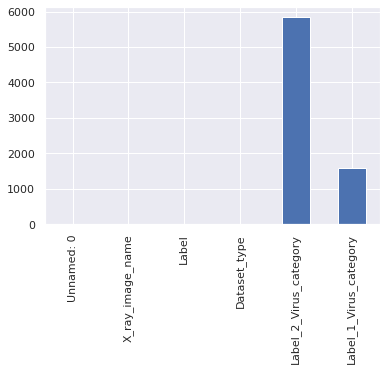

In [7]:
missing_vals = train_df.isnull().sum()
missing_vals.plot(kind = 'bar')

In [8]:
train_df.dropna(how = 'all')
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [9]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5289,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN
5651,5674,person121_bacteria_578.jpeg,Pnemonia,TEST,NaN,bacteria
5857,5880,person174_bacteria_832.jpeg,Pnemonia,TEST,NaN,bacteria
5672,5695,person113_bacteria_542.jpeg,Pnemonia,TEST,NaN,bacteria
5774,5797,person78_bacteria_385.jpeg,Pnemonia,TEST,NaN,bacteria
5719,5742,person96_bacteria_464.jpeg,Pnemonia,TEST,NaN,bacteria
5550,5573,person157_bacteria_740.jpeg,Pnemonia,TEST,NaN,bacteria
5868,5891,person1679_virus_2896.jpeg,Pnemonia,TEST,NaN,Virus
5597,5620,person139_bacteria_661.jpeg,Pnemonia,TEST,NaN,bacteria
5771,5794,person78_virus_140.jpeg,Pnemonia,TEST,NaN,Virus


fill the missing values with unknown

In [10]:
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')
display(train_fill.head(5))

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown


Visualization of Unknown Data

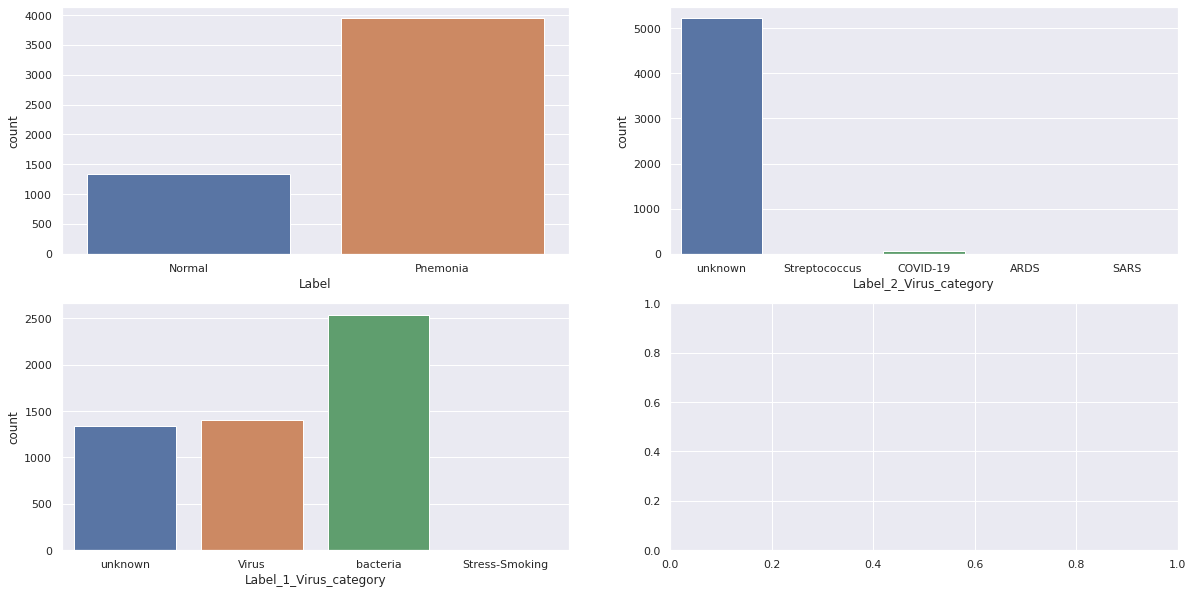

In [11]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2,2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

In [12]:
test_img_dir = '/content/drive/MyDrive/Colab Notebooks/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_img_dir = '/content/drive/MyDrive/Colab Notebooks/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(test_img_dir) == True
assert os.path.isdir(train_img_dir) == True

sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

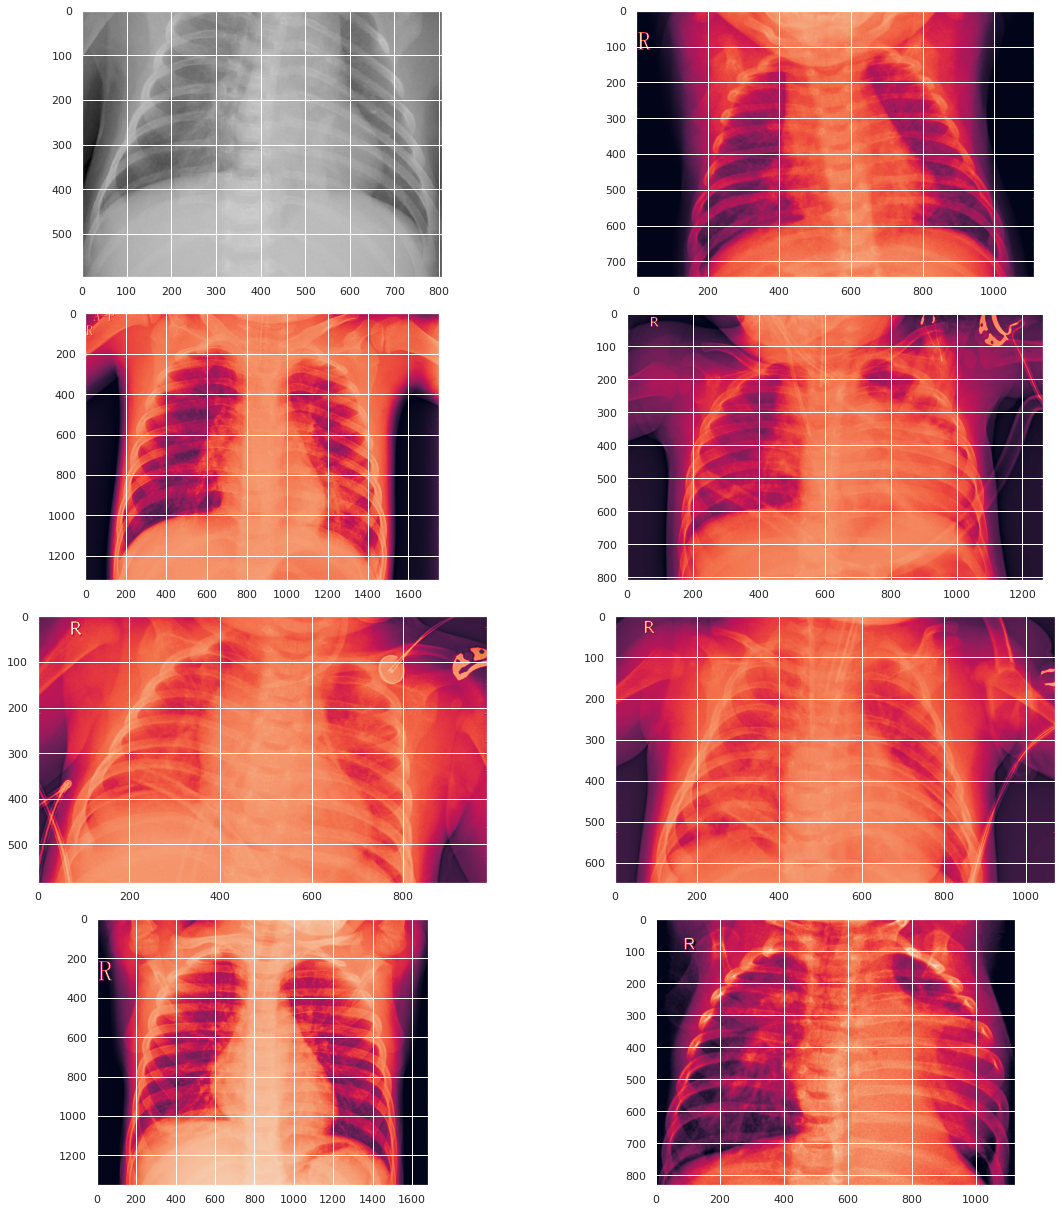

In [13]:
from PIL import Image
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

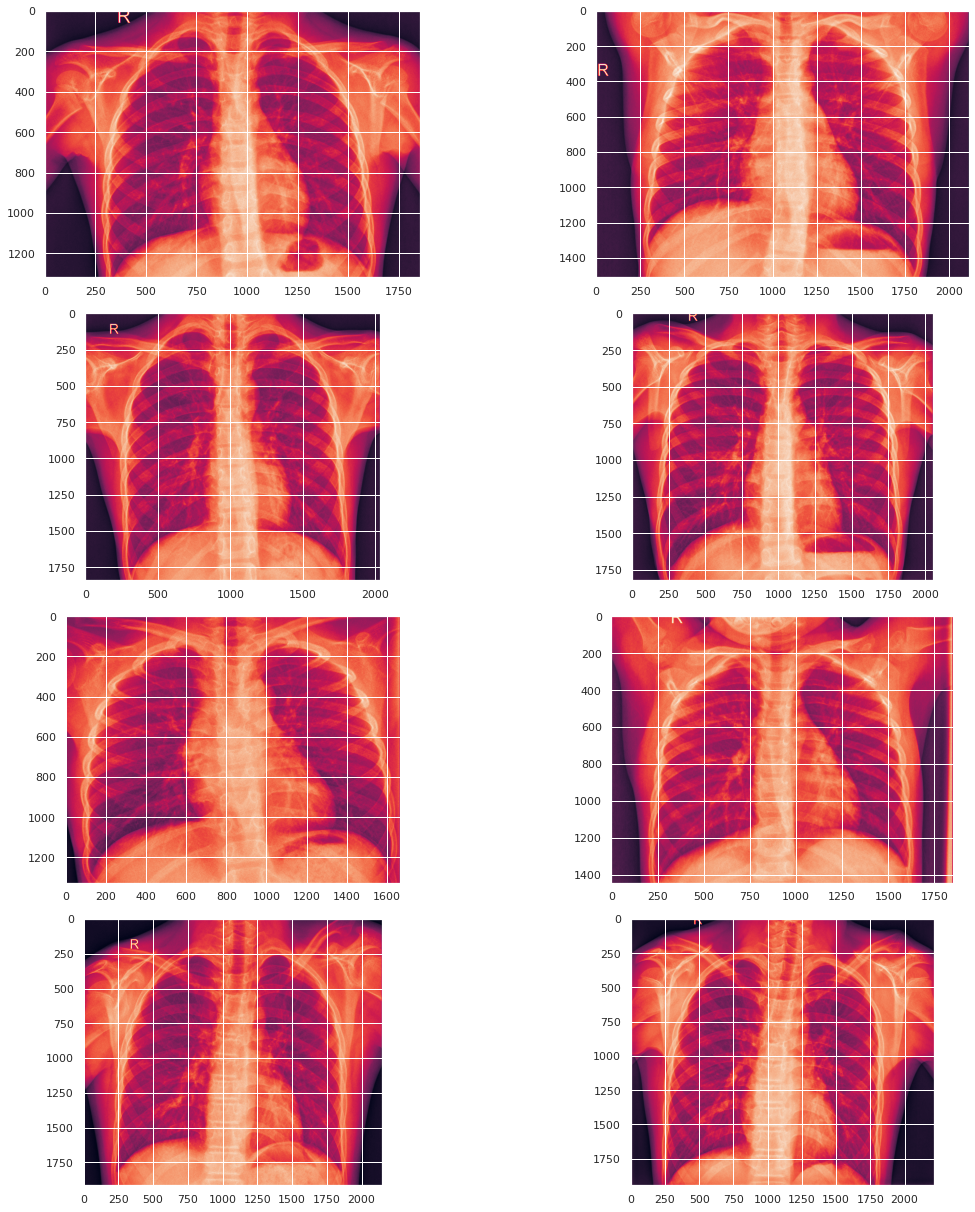

In [14]:
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

Histogram analysis of Images

For COVID-19 cases

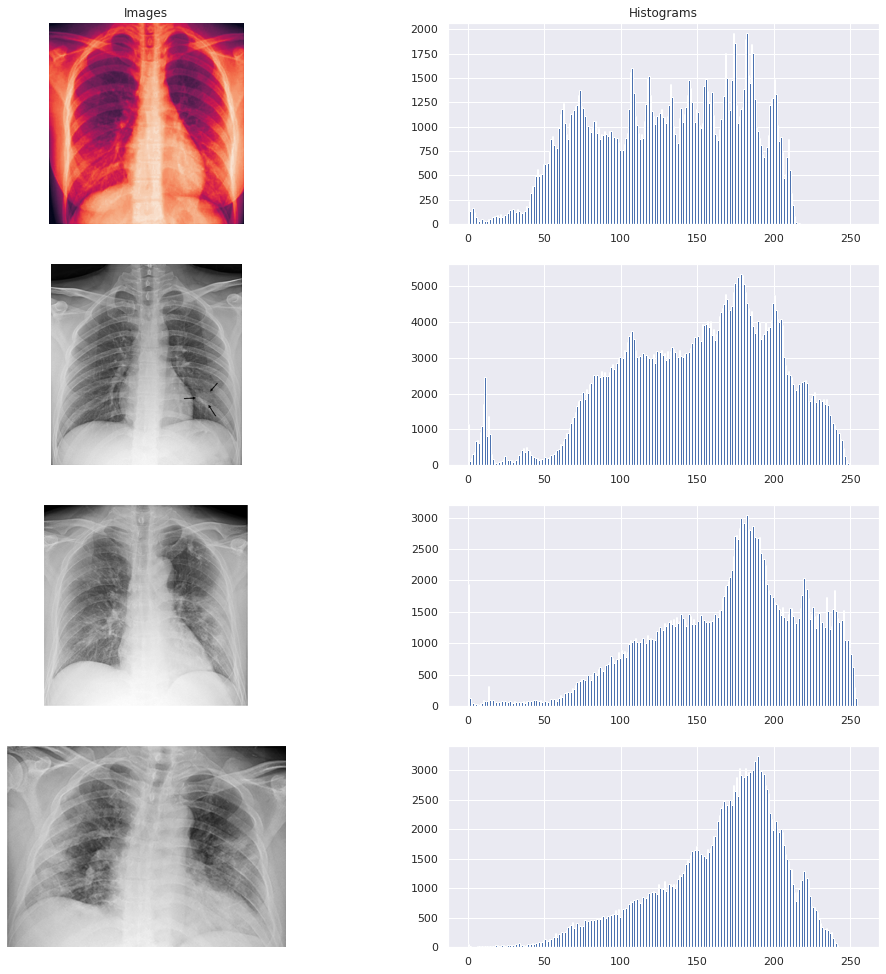

In [15]:
ig, ax = plt.subplots(4, 2, figsize=(17, 17))


covid_path = train_data[train_data['Label_2_Virus_category']=='COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=12)
plt.show()

Normal Histogram images

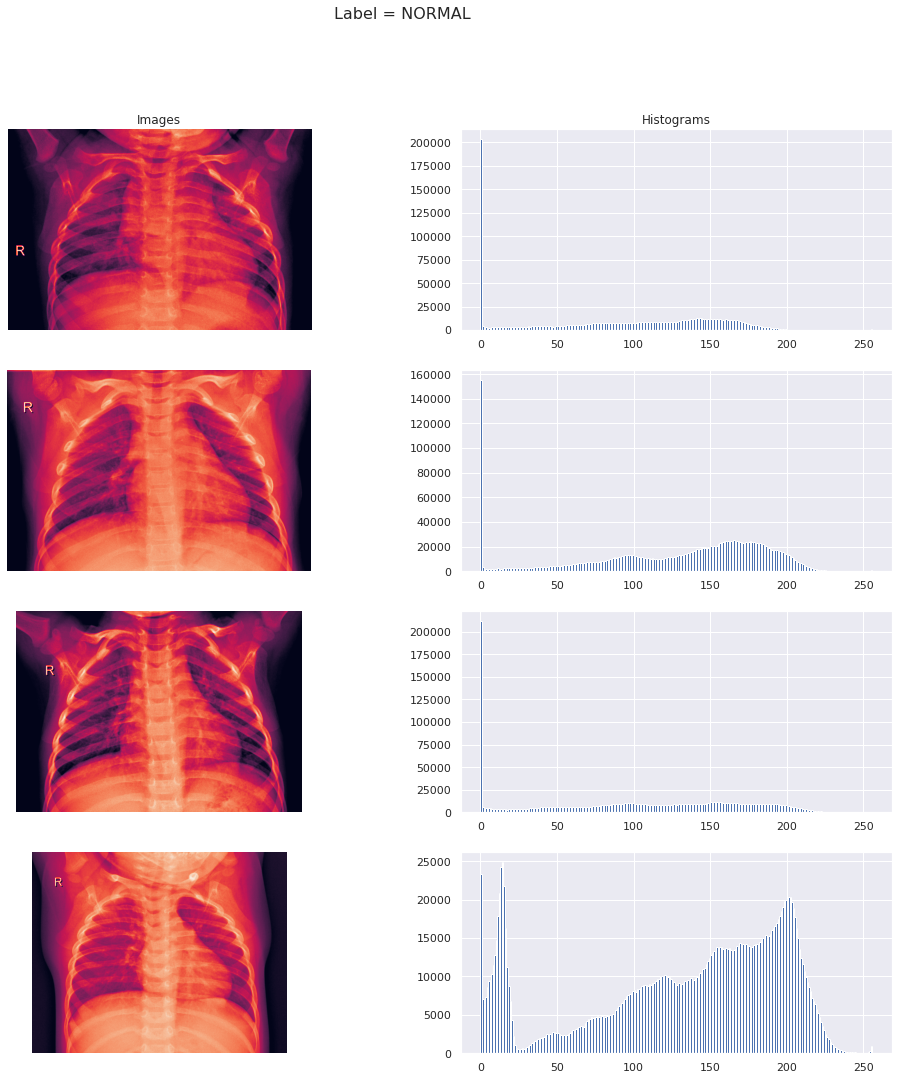

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))


normal_path = train_data[train_data['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

Image Augmentation

In [17]:
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 7)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,target
408,408,IM-0553-0001-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
390,390,IM-0568-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
5223,5228,kjr-21-e24-g002-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive
1215,1215,NORMAL2-IM-1257-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
364,364,IM-0539-0001-0002.jpeg,Normal,TRAIN,NaN,NaN,negative
1227,1227,NORMAL2-IM-1240-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
54,54,IM-0222-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
330,330,IM-0517-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
147,147,IM-0369-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1129,1129,NORMAL2-IM-1120-0001.jpeg,Normal,TRAIN,NaN,NaN,negative


In [18]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


Model Development

Convolutional Neural Network

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape= (224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Dropout(0.5))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [22]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [23]:
BATCH_SIZE = 16
EPOCHS = 30

In [26]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator,
                              steps_per_epoch = train_generator.samples //BATCH_SIZE,
                              validation_data=validation_generator,
                              epochs=EPOCHS,
                              validation_steps= validation_generator.samples //BATCH_SIZE,
                              callbacks = [callbacks]
                   )

Epoch 1/30
62/62 [==============================] - 58s 927ms/step - loss: 0.2011 - accuracy: 0.9614 - val_loss: 0.1818 - val_accuracy: 0.9425
Epoch 2/30
62/62 [==============================] - 56s 902ms/step - loss: 0.1461 - accuracy: 0.9654 - val_loss: 0.1701 - val_accuracy: 0.9425
Epoch 3/30
62/62 [==============================] - 55s 896ms/step - loss: 0.1239 - accuracy: 0.9654 - val_loss: 0.1017 - val_accuracy: 0.9475
Epoch 4/30
62/62 [==============================] - 55s 898ms/step - loss: 0.0901 - accuracy: 0.9705 - val_loss: 0.1378 - val_accuracy: 0.9425
Epoch 5/30
62/62 [==============================] - 54s 882ms/step - loss: 0.0941 - accuracy: 0.9675 - val_loss: 0.1378 - val_accuracy: 0.9425


Plots to estimate loss and accuracy

Text(0.5, 1.0, 'Metrics estimations')

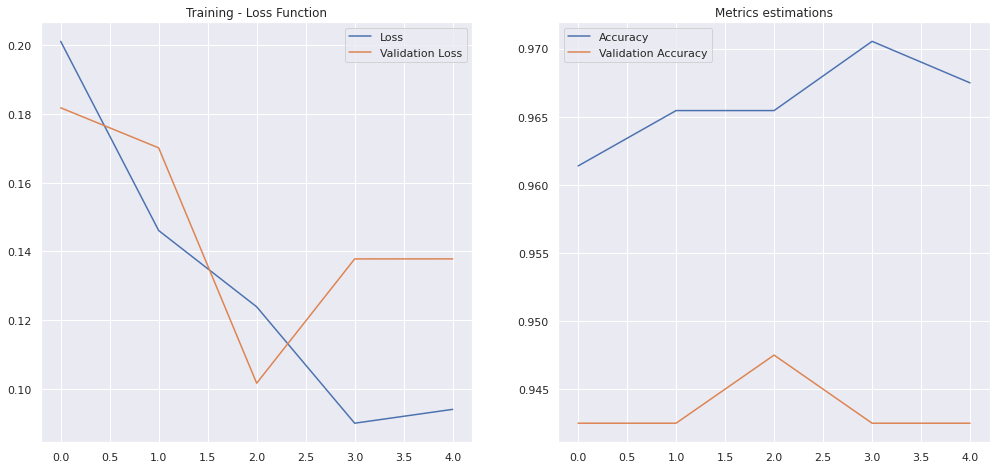

In [27]:
plt.figure(figsize=(17,17))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')

# cnn archi

MobileNetV2

In [28]:
mob_model = Sequential()
mob_model.add(tf.keras.applications.MobileNetV2(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
mob_model.add(Dense(32, activation='relu'))
mob_model.add(Dense(1, activation='sigmoid'))
mob_model.layers[0].trainable = False
mob_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


In [29]:
mob_history = mob_model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                              validation_data=validation_generator,
                              epochs=20,
                              validation_steps=len(validation_generator),
                              callbacks = [callbacks]
                                     )

Epoch 1/20
63/63 [==============================] - 60s 897ms/step - loss: 0.1822 - accuracy: 0.9430 - val_loss: 0.1016 - val_accuracy: 0.9425
Epoch 2/20
63/63 [==============================] - 55s 872ms/step - loss: 0.0584 - accuracy: 0.9650 - val_loss: 0.0634 - val_accuracy: 0.9425
Epoch 3/20
63/63 [==============================] - 55s 880ms/step - loss: 0.0472 - accuracy: 0.9800 - val_loss: 0.0518 - val_accuracy: 0.9775
Epoch 4/20
63/63 [==============================] - 55s 876ms/step - loss: 0.0325 - accuracy: 0.9880 - val_loss: 0.0554 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 54s 866ms/step - loss: 0.0222 - accuracy: 0.9910 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch 6/20
63/63 [==============================] - 53s 851ms/step - loss: 0.0149 - accuracy: 0.9940 - val_loss: 0.0327 - val_accuracy: 0.9825
Epoch 7/20
63/63 [==============================] - 53s 853ms/step - loss: 0.0165 - accuracy: 0.9930 - val_loss: 0.0222 - val_accuracy: 0.9900

Text(0.5, 1.0, 'Train - Accuracy')

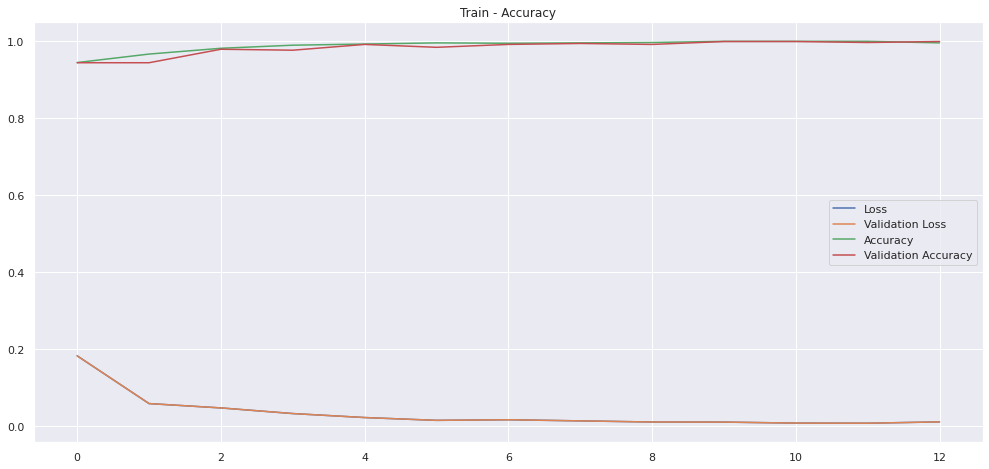

In [30]:
plt.figure(figsize=(17,17))

plt.subplot(2, 1, 2)
plt.plot(mob_history.history['loss'], label='Loss')
plt.plot(mob_history.history['loss'], label='Validation Loss')

plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 1, 2)
plt.plot(mob_history.history['accuracy'], label='Accuracy')
plt.plot(mob_history.history['val_accuracy'], label='Validation Accuracy')


plt.legend()
plt.title('Train - Accuracy')

In [31]:
label = validation_generator.classes
print('Cases summary of the models : \n{}'.format(label))

Cases summary of the models : 
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

CNN predictions

In [32]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

In [33]:
labels

{'negative': 0, 'positive': 1}

In [34]:
print('CNN Model Predictions : \n{}'.format(predictions))

CNN Model Predictions : 
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'n

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[377,  23],
       [  0,   0]])

In [36]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,377,377
1,23,23
All,400,400


              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       400
    Positive       0.00      0.00      0.00         0

    accuracy                           0.94       400
   macro avg       0.50      0.47      0.49       400
weighted avg       1.00      0.94      0.97       400



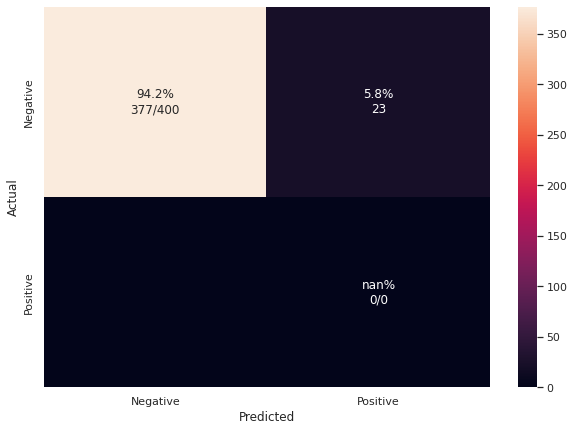

In [37]:
import seaborn as sns

matrix_index = ["Negative", "Positive"]
# Negative - no COVID


preds = model.predict(validation_generator)
classpreds = np.argmax(preds, axis=1) # predicted classes 
#y_testclass = np.argmax(valida, axis=1) # true classes

cm = confusion_matrix(predicted_class_indices,label)
print(classification_report(predicted_class_indices,label, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

MobileNet predictions

In [38]:
pred= mob_model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

In [39]:
labels

{'negative': 0, 'positive': 1}

In [40]:
print('MobileNet Model Predictions : \n{}'.format(predictions))

MobileNet Model Predictions : 
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negativ

In [41]:
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[377,  23],
       [  0,   0]])

In [42]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,377,377
1,23,23
All,400,400


              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       400
    Positive       0.00      0.00      0.00         0

    accuracy                           0.94       400
   macro avg       0.50      0.47      0.49       400
weighted avg       1.00      0.94      0.97       400



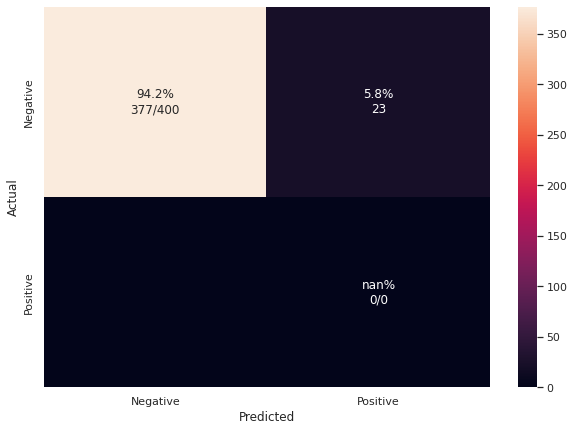

In [43]:
matrix_index = ["Negative", "Positive" ]
# Negative - no COVID

preds = mob_model.predict(validation_generator)
classpreds = np.argmax(preds, axis=1) # predicted classes 
#y_testclass = np.argmax(valida, axis=1) # true classes

cm = confusion_matrix(predicted_class_indices,label)
print(classification_report(predicted_class_indices,label, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')